# Prediction

In [3]:
import pandas as pd

## Load df from CSV

In [4]:
df = pd.read_csv('./dataset.csv')

# Also prepare for the prediction (see transform)
df = df.drop(columns='customerID')
df = df.dropna(how='any')
df['gender'] = df['gender'].map({'Male' : 0, 'Female' : 1})
df['Churn'] = df['Churn'].map({'Yes' : 1, 'No' : 0})
bin_features = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for bin_feature in bin_features:
    df[bin_feature] = df[bin_feature].map({'Yes' : 1, 'No' : 0})
bin_features = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for bin_feature in bin_features:
    df[bin_feature] = df[bin_feature].map({'Yes' : 1, 'No' : 0, 'No internet service' : 0, 'No phone service' : 0})
cat_features = ['InternetService', 'Contract', 'PaymentMethod']
for cat_feature in cat_features:
    df = pd.concat([df, pd.get_dummies(df[cat_feature])], axis=1).drop(columns=cat_feature)
df.loc[df['TotalCharges'] == ' ', 'TotalCharges'] = '0.0'

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,DSL,Fiber optic,No,Month-to-month,One year,Two year,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
0,1,0,1,0,1,0,0,0,1,0,...,True,False,False,True,False,False,False,False,True,False
1,0,0,0,0,34,1,0,1,0,1,...,True,False,False,False,True,False,False,False,False,True
2,0,0,0,0,2,1,0,1,1,0,...,True,False,False,True,False,False,False,False,False,True
3,0,0,0,0,45,0,0,1,0,1,...,True,False,False,False,True,False,True,False,False,False
4,1,0,0,0,2,1,0,0,0,0,...,False,True,False,True,False,False,False,False,True,False


## Train-Test Split

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.drop(columns='Churn'), df['Churn'], test_size=0.25)

## Model Fit-Predict

In [6]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000000)

lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)

## Accuracy, F1 and Confusion Matrix

Logistic Regression: 
Accuracy:           0.7978421351504826 
F1-score:           0.5801886792452831 
Confusion Matrix:


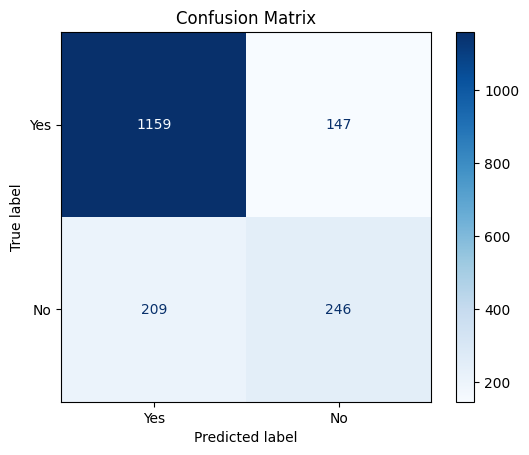

In [7]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Yes', 'No'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

print(f"""Logistic Regression: 
Accuracy:           {accuracy_score(y_test, lr_pred)} 
F1-score:           {f1_score(y_test, lr_pred)} 
Confusion Matrix:""")
plot_confusion_matrix(confusion_matrix(y_test, lr_pred))